# 토마토 잎병 데이터

* 10개의 질병과 1개의 건강한 클래스로 되어있는 2만개 이상의 토마토 사진 데이터를 딥러닝을 이용해 분류하는 것이 목표입니다.


* 클래스
    * Bacterial_spot 박테리아스팟
    * Early_blight 곰팡이로 인한 병; 잎에 반점이 생기거나 잎이 탈락하거나 발육 불량이 되는 것이 특징.
    * Late_blight 잎 마름 병
    * Leaf_Mold 부엽토, 부식토
    * Septoria_leaf_spot 흰무니병?
    * Spider_mites Two-spotted_spider_mite 두 점박이 응애 해충에 일종인데 잎에 반점 같은 손상을 입히는 듯?
    * Target_Spot 곰팡이 병원균인 Corynespora cassiicola에 의해 발생함 반점
    * Tomato_Yellow_Leaf_Curl_Virus 토마토황화잎말림바이러스 가루이 라는 벌레 한테 전염 됨 
    * healthy 건강한 토마토
    * powdery_mildew 흰가루병


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as Data
import torch.optim as optim
import typing
import torchvision
import torchvision.transforms as transforms
import os
import gc
from tqdm import tqdm # 셀 진행 상황을 알려줌 

In [ ]:
# 훈련 데이터를 변환합니다. 
train_dataset = torchvision.datasets.ImageFolder(root = r"/kaggle/input/tomato/train",
                                                 transform = torchvision.transforms.Compose(
                                                [torchvision.transforms.Resize((256,256)),
                                                torchvision.transforms.ToTensor(),
                                                torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                                                     std=[0.5, 0.5, 0.5])]))




# transforms.Compose 데이터를 여러 단계로 변환해야 하는 경우, Compose를 통해 여러 단계를 묶을 수 있다.(리사이즈,투텐서,노말라이즈를 안에 넣기 위함)
# Normalize(정규화) 안해주고 ToTensor만 하면 범위가 0~1사이의 픽셀로 변환됨(transforms)
#transofrms.Normalize((R채널 평균, G채널 평균, B채널 평균), (R채널 표준편차, G채널 표준편차, B채널 표준편차)) 0.5씩 해주면
# -1~1사이의 픽셀로 변환 
# 정규화를 하는 이유 오차역전파시 gradient 계산을 수행할 때 데이터가 유사한 범위를 가지게 하기 위함 
train_dataset[0][0].shape # 색상3 세로 256 가로 256의 텐서화된 데이터 

torch.Size([3, 256, 256])

In [ ]:
train_dataset.classes


['Bacterial_spot',
 'Early_blight',
 'Late_blight',
 'Leaf_Mold',
 'Septoria_leaf_spot',
 'Spider_mites Two-spotted_spider_mite',
 'Target_Spot',
 'Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato_mosaic_virus',
 'healthy',
 'powdery_mildew']

In [ ]:
# 테스트 데이터를 변환합니다.
test_dataset = torchvision.datasets.ImageFolder(root="/kaggle/input/tomato/valid",
                                                transform = torchvision.transforms.Compose(
                                                [torchvision.transforms.Resize((256,256)),
                                                torchvision.transforms.ToTensor(),
                                                torchvision.transforms.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5])
                                                ]
                                                
                                                )
                                               
                                               
                                               
                                               
                                               
                                               
                                               
                                               
                                               )

In [ ]:
test_dataset[0][0].shape

torch.Size([3, 256, 256])

In [ ]:
Batch_size=4

dl_train =torch.utils.data.DataLoader(
        train_dataset,
        batch_size=Batch_size,
        shuffle=True

)

dl_test = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=Batch_size,
        shuffle=True
    
)

In [ ]:
model=torchvision.models.efficientnet_b7(pretrained=True) 
n_inputs = model.classifier[1].in_features #입력층 in_features input sample의 size
model.classifier[1]=nn.Linear(n_inputs,11) #출력층 11(클래스가 11개니까)
# nn.Linear(input,output)인풋과 아웃풋을 선형 결합

Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-dcc49843.pth


  0%|          | 0.00/255M [00:00<?, ?B/s]

## efficientnet_b7 model
![image.png](attachment:bf0de25f-9c9f-4aa1-924f-d6dcd80845a4.png)

In [ ]:
loss_fn =nn.CrossEntropyLoss() # 다중분류 대표적인 함수 크로스엔트로피함수를 씁니다.
optim = torch.optim.Adam(model.parameters(), lr=0.0001) 
# 최적화알고리즘 Adam 사용 모델 내부정보를 넘겨주는 model.parameters 와 학습률 0.0001 설정
if torch.cuda.is_available():model.to('cuda') #gpu 사용 가능 상태면 -> gpu 사용
    



In [ ]:
def fit(epoch, model, trainloader, testloader):
    correct = 0 # 정답을 넣을 곳
    total = 0
    running_loss = 0
    model.train()
    for x, y in tqdm(trainloader): #x 데이터 y 정답 
        if torch.cuda.is_available():
            x, y = x.to('cuda'), y.to('cuda')
        y_pred = model(x)
        loss = loss_fn(y_pred, y) #예측값과 실제값 오차 구하기
        optim.zero_grad() # 오차역전파 하기 전에 기울기 초기화
        loss.backward() # 오차역전파
        optim.step() # 오차역전파한 값으로 정의한 알고리즘에 맞추어 가중치를 수정
        with torch.no_grad(): #with이 끝날 때 까지만 기울기 계산
            y_pred = torch.argmax(y_pred, dim=1) # argmax 가장 큰 값을 가지는 dim=1(열)을 반환 
            correct += (y_pred == y).sum().item() #예측값 = 진짜값인 것들을 다 더해서 스칼라화 한 후 correct에 넣기 
            total += y.size(0)
            running_loss += loss.item()

    epoch_loss = running_loss / len(trainloader.dataset)
    epoch_acc = correct / total

    test_correct = 0
    test_total = 0
    test_running_loss = 0
    model.eval()
    with torch.no_grad():
        for x, y in tqdm(testloader):
            if torch.cuda.is_available():
                x, y = x.to('cuda'), y.to('cuda')
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            y_pred = torch.argmax(y_pred, dim=1)
            test_correct += (y_pred == y).sum().item()
            test_total += y.size(0)
            test_running_loss += loss.item()

    epoch_test_loss = test_running_loss / len(testloader.dataset)
    epoch_test_acc = test_correct / test_total

    print('epoch: ', epoch,
          'loss： ', round(epoch_loss, 3),
          'accuracy:', round(epoch_acc, 3),
          'test_loss： ', round(epoch_test_loss, 3),
          'test_accuracy:', round(epoch_test_acc, 3)
          )

    return epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc

In [ ]:
epochs = 10

train_loss = []
train_acc = []
test_loss = []
test_acc = []

for epoch in range(epochs):
    gc.collect() #가비지 콜렉션
    torch.cuda.empty_cache() # 사용되지 않는 GPU상 cache를 정리
    epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc = fit(epoch,
                                                                 model,
                                                                 dl_train,
                                                                 dl_test
                                                                )
    torch.save(model.state_dict(), os.path.join(r"/kaggle/working/","acc"+ str(epoch_test_acc) + ".pt"))
    # model.state_dict()로 가중치 저장한 값을 torch.save로 파일로 저장
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

100%|██████████| 1671/1671 [01:45<00:00, 15.77it/s]


epoch:  0 loss：  0.13 accuracy: 0.836 test_loss：  0.043 test_accuracy: 0.949


100%|██████████| 1671/1671 [01:46<00:00, 15.74it/s]


epoch:  1 loss：  0.042 accuracy: 0.947 test_loss：  0.04 test_accuracy: 0.958


100%|██████████| 1671/1671 [01:46<00:00, 15.65it/s]


epoch:  2 loss：  0.026 accuracy: 0.967 test_loss：  0.049 test_accuracy: 0.948


100%|██████████| 1671/1671 [01:45<00:00, 15.88it/s]


epoch:  3 loss：  0.018 accuracy: 0.977 test_loss：  0.052 test_accuracy: 0.951


100%|██████████| 1671/1671 [01:45<00:00, 15.78it/s]


epoch:  4 loss：  0.014 accuracy: 0.983 test_loss：  0.046 test_accuracy: 0.955


100%|██████████| 1671/1671 [01:45<00:00, 15.81it/s]


epoch:  5 loss：  0.013 accuracy: 0.985 test_loss：  0.054 test_accuracy: 0.953


100%|██████████| 1671/1671 [01:46<00:00, 15.73it/s]


epoch:  6 loss：  0.011 accuracy: 0.987 test_loss：  0.043 test_accuracy: 0.969


100%|██████████| 1671/1671 [01:46<00:00, 15.68it/s]


epoch:  7 loss：  0.01 accuracy: 0.988 test_loss：  0.048 test_accuracy: 0.961


100%|██████████| 1671/1671 [01:46<00:00, 15.73it/s]


epoch:  8 loss：  0.009 accuracy: 0.989 test_loss：  0.035 test_accuracy: 0.974


100%|██████████| 1671/1671 [01:51<00:00, 14.97it/s]


epoch:  9 loss：  0.008 accuracy: 0.99 test_loss：  0.038 test_accuracy: 0.969


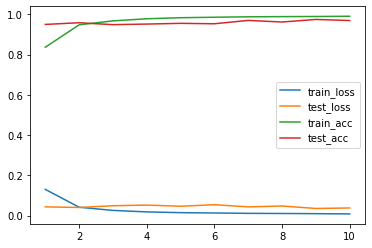

In [ ]:
plt.plot(range(1, epochs+1), train_loss, label='train_loss')
plt.plot(range(1, epochs+1), test_loss, label='test_loss')
plt.legend()
plt.plot(range(1, epochs+1), train_acc, label='train_acc')
plt.plot(range(1, epochs+1), test_acc, label='test_acc')
plt.legend()
plt.show()